In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def minmax(df):
    df = df - df.min()
    return df / df.max()

def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()


## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [6]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)
data=pd.concat([m_data,f_data])

In [7]:
print(data.groupby(['age', 'sex']).size().reset_index(name='count'))

     age sex  count
0    4.0   f     15
1    4.0   m     14
2    8.0   f     16
3    8.0   m     16
4   12.0   f     16
5   12.0   m     15
6   20.0   f     15
7   20.0   m     16
8   24.0   f     16
9   24.0   m     16
10  28.0   f     10
11  28.0   m     14
12  32.0   f     16
13  32.0   m     16
14  36.0   f     16
15  36.0   m     14
16  40.0   f     16
17  40.0   m     15
18  44.0   f     16
19  44.0   m     15
20  48.0   f     16
21  48.0   m     15
22  52.0   f     14
23  52.0   m     15
24  56.0   f     16
25  56.0   m     15
26  60.0   f     15
27  60.0   m     16
28  64.0   f     15
29  64.0   m     13
30  68.0   f     15
31  68.0   m     15
32  72.0   f     16
33  72.0   m     15
34  78.0   f     16
35  78.0   m     16
36  80.0   f     15
37  80.0   m     14
38  84.0   f     16
39  84.0   m     16
40  90.0   f     11
41  90.0   m     16


In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

In [9]:
# look at syllable usage diff male and females according to actual age
df =m_data.groupby('age').mean()-f_data.groupby('age').mean()

In [10]:
# upload syllable classes
syllable_classes = pd.read_csv('./v11_syllable_labels_v2.csv')
id_map = syllable_classes.set_index('Original ID')['Class']
class_sort = [id_map[k] for k in df.columns]

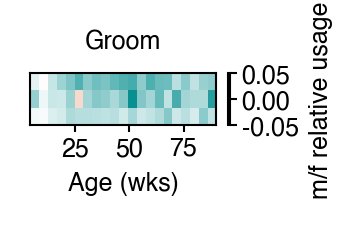

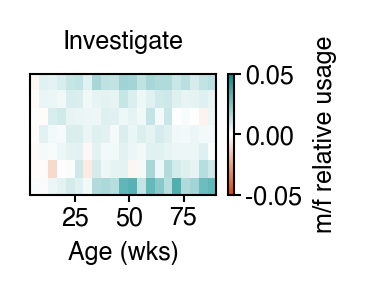

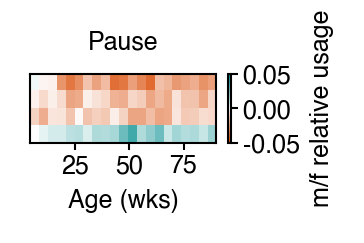

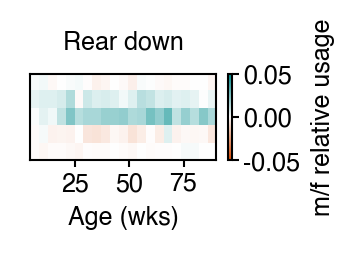

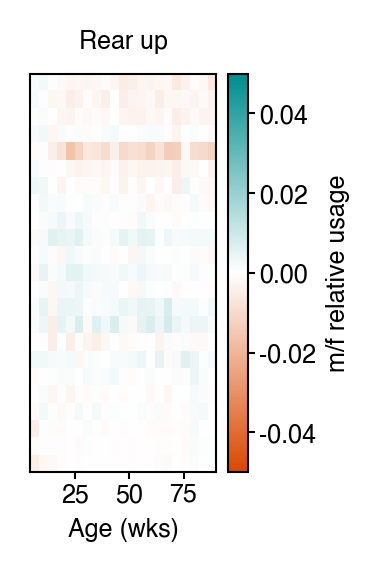

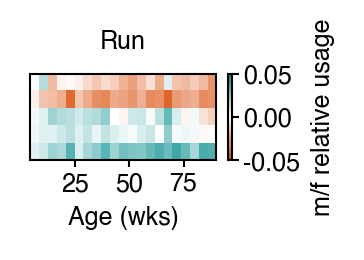

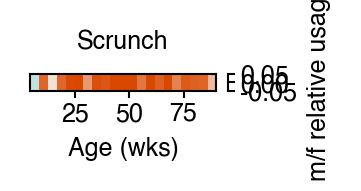

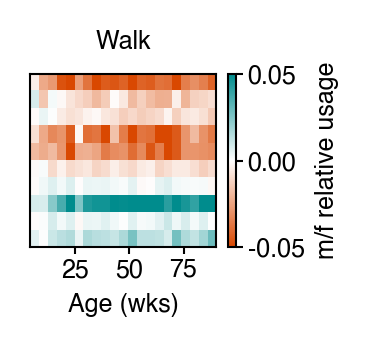

In [11]:
class_avgs = {}
class_norm_avgs = {}
for _class, _df in df.T.groupby(class_sort):
    avgs = _df.T.groupby('age').mean()
    class_avgs[_class] = avgs.mean(1)

    #norm_avgs = minmax(avgs)
    norm_avgs = avgs

    peaks = (
        norm_avgs.rolling(7, min_periods=1, center=True, win_type="exponential")
        .mean(tau=3)
        .idxmax()
    )
    peaks = peaks.sort_values()
    class_norm_avgs[_class] = norm_avgs.mean(1)

    ages = avgs.index

    fig = figure(1, 0.075 * avgs.shape[1])
    plt.imshow(norm_avgs[peaks.index].T, cmap=cmmf, extent=(ages[0], ages[-1], avgs.shape[1], 0), aspect='auto',
               vmin=-0.05,
              vmax=0.05,
              )
    plt.title(_class)
    plt.colorbar(label="m/f relative usage")
    plt.yticks([])
    plt.xlabel("Age (wks)")
    #sns.despine()
    c = PlotConfig()
    fig.savefig(c.dana_save_path / "fig1"/ f'fvm_relative_usage_class-{_class}.pdf')


In [12]:
class_df = pd.DataFrame(class_norm_avgs)
peaks = (
    class_df.rolling(7, min_periods=1, center=True, win_type="exponential")
    .mean(tau=3)
    .idxmax()
)
peaks = peaks.sort_values()

In [13]:
col_order = ['Pause', 'Scrunch', 'Groom', 'Rear down','Rear up','Run','Investigate','Walk']
class_df_new = class_df.reindex(columns=col_order)

<Axes: xlabel='age'>

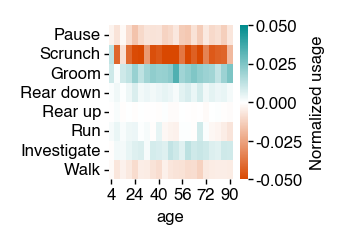

In [14]:
format_plots()
fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(class_df_new.T, cmap=cmmf, vmax=0.05, vmin=-0.05, cbar_kws=dict(label='Normalized usage'))

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_relative_usage_syllable_classes.pdf')

In [16]:
#stats

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

In [18]:
def tw_anova(data, dependent_var, factor1, factor2):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    #model = ols(f'ranked_response ~ {factor1} * {factor2}', data=align_data).fit()
    model = ols(f'ranked_response ~ {factor1} * C({factor2})', data=align_data).fit()

    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df

In [19]:
# find classes for males:
df=m_data.copy()
class_avgs = {}
class_norm_avgs = {}
for _class, _df in df.T.groupby(class_sort):
    avgs = _df.T.groupby(['age','uuid']).mean()
    class_avgs[_class] = avgs.mean(1)

    norm_avgs = minmax(avgs)
    norm_avgs = avgs.copy()
    class_norm_avgs[_class] = norm_avgs.mean(1)
    ages = avgs.index
class_df = pd.DataFrame(class_norm_avgs)
col_order = ['Pause', 'Scrunch', 'Groom', 'Rear down','Rear up','Run','Investigate','Walk']
class_df_male = class_df.reindex(columns=col_order)
class_df_male['sex']='m'

In [20]:
# find classes for females:
df=f_data.copy()
class_avgs = {}
class_norm_avgs = {}
for _class, _df in df.T.groupby(class_sort):
    avgs = _df.T.groupby(['age','uuid']).mean()
    class_avgs[_class] = avgs.mean(1)

    #norm_avgs = minmax(avgs)
    norm_avgs = avgs.copy()
    class_norm_avgs[_class] = norm_avgs.mean(1)
    ages = avgs.index
class_df = pd.DataFrame(class_norm_avgs)
col_order = ['Pause', 'Scrunch', 'Groom', 'Rear down','Rear up','Run','Investigate','Walk']
class_df_female = class_df.reindex(columns=col_order)
class_df_female['sex']='f'

In [21]:
data = pd.concat([class_df_male,class_df_female])
data.set_index('sex', append=True, inplace=True)
temp = data.copy()
temp.reset_index(inplace=True)

syll = data.columns
n=len(syll)
results={}
a = 0.05

# Initialize variables
results = []
dependent_vars = data.columns
n_tests = len(dependent_vars)  # Number of ANOVA tests

# Perform ANOVA for each dependent variable
for i, k in enumerate(dependent_vars):
    print(k)
    anova_results = tw_anova(temp, k, 'age', 'sex')
    anova_results['Dependent Variable'] = k  # Add dependent variable to the results
    results.append(anova_results)
    print(tabulate(anova_results, headers='keys', tablefmt='psql'))

# Combine results into a DataFrame
results_df = pd.concat(results).reset_index()
results_df.rename(columns={'index': 'Parameter'}, inplace=True)

# Move the 'Dependent Variable' column to the first position
cols = ['Dependent Variable'] + [col for col in results_df.columns if col != 'Dependent Variable']
results_df = results_df[cols]

# Apply Bonferroni correction to the p-values
results_df['Bonferroni_corrected_p'] = results_df['PR(>F)'] * n_tests
results_df['Bonferroni_corrected_p'] = results_df['Bonferroni_corrected_p'].apply(lambda p: min(p, 1))  # p-values should not exceed 1

# Save DataFrame to CSV file
results_df.to_csv('anova_results_fvm_ontogeny_per_class_07_07.csv', index=False)

print("ANOVA results with Bonferroni-corrected p-values have been saved to .csv'")

Pause
+------------+-------------+------+------------+----------------+----------------------+
|            |      sum_sq |   df |          F |         PR(>F) | Dependent Variable   |
|------------+-------------+------+------------+----------------+----------------------|
| Intercept  | 0.0573853   |    1 | 1801.92    |   6.10023e-187 | Pause                |
| C(sex)     | 0.0017728   |    1 |   55.6666  |   2.8614e-13   | Pause                |
| age        | 0.000312776 |    1 |    9.82127 |   0.00180519   | Pause                |
| age:C(sex) | 0.00021708  |    1 |    6.81638 |   0.00924747   | Pause                |
| Residual   | 0.0200635   |  630 |  nan       | nan            | Pause                |
+------------+-------------+------+------------+----------------+----------------------+
Scrunch
+------------+------------+------+------------+----------------+----------------------+
|            |     sum_sq |   df |          F |         PR(>F) | Dependent Variable   |
|--------

In [22]:
## 